In [14]:
!pip3 install obci_readmanager

In [15]:
#Importy
import pandas as pd
from obci_readmanager.signal_processing.read_manager import ReadManager
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import scipy.signal as ss
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import iirnotch
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów
from  scipy.signal import butter
import matplotlib.collections as collections

In [16]:
#Ustawiam domyślne wielkości wykresów
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100 

2021-05-04 11:35:15,491 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


['nos1', 'nos2', 'czolo1', 'czolo2', 'corr1', 'corr2', 'TSS']
[{'start_timestamp': 9.52323031425476, 'end_timestamp': 10.023003101348877, 'name': '01f_an_c.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 11.039291143417358, 'end_timestamp': 11.522360801696777, 'name': '01F_DI_C.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 12.53892993927002, 'end_timestamp': 13.021961450576782, 'name': '01F_FE_C.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 14.038392782211304, 'end_timestamp': 14.521395444869995, 'name': '02f_an_c.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 15.523666143417358, 'end_timestamp': 16.0257351398468, 'name': '02f_di_c.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 17.037221908569336, 'end_timestamp': 17.521049976348877, 'name': '02F_FE_C.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 18.53678846359253, 'end_timestamp': 19.020472288131714, 'name': '01f_an_c.bmp', 'channels': '', 'desc': {}}, {'start_timestamp': 20.0365180969

Text(0, 0.5, 'Napięcie [uV]')

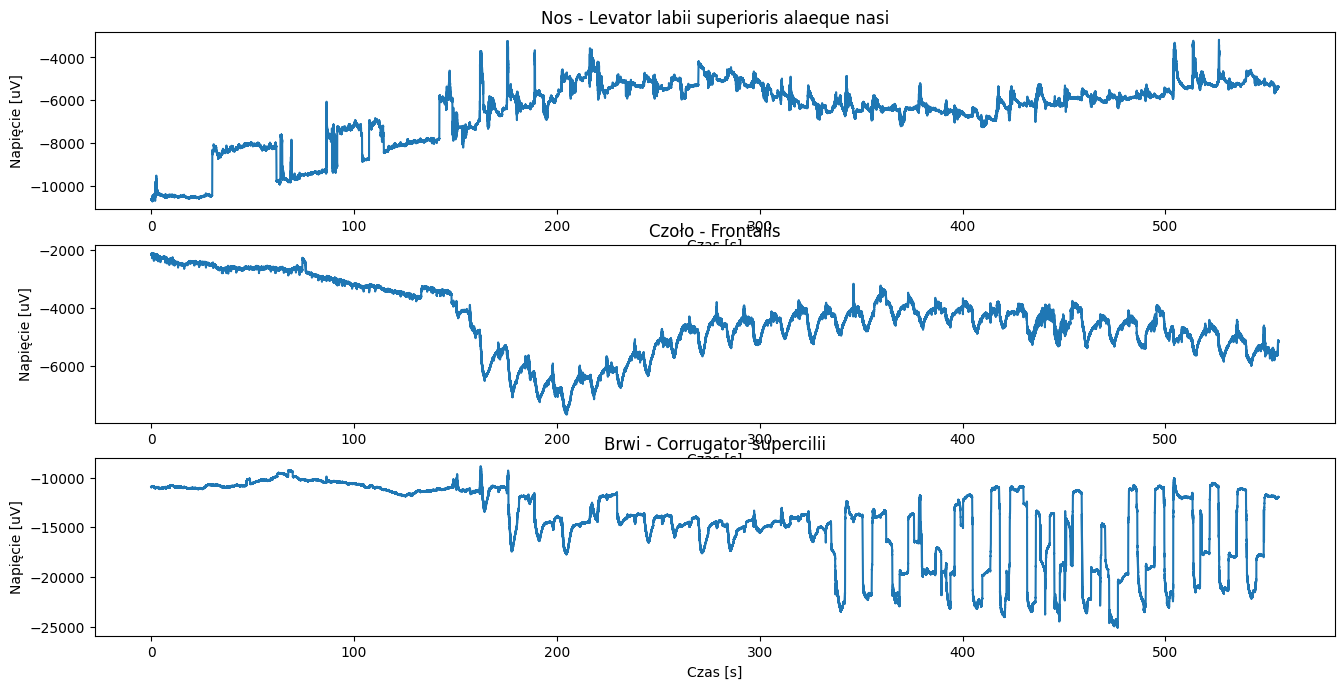

In [17]:
# Utwórz obiekt klasy ReadManager podając na wejściu
# ścieżki do odpowiednich plików
emg = ReadManager("natalia_twarz_test_final_final.xml", "natalia_twarz_test_final_final.raw", "natalia_twarz_test_final_final.tag")

# Pobierz informacje o sygnale
sampling = float(emg.get_param("sampling_frequency"))
num_of_channels = int(emg.get_param("number_of_channels"))
channels_names = emg.get_param("channels_names")

print(channels_names)

# Pobierz cały sygnał
syg = emg.get_microvolt_samples()

# Pobierz cały, wybrany kanał
b1 = emg.get_channel_samples("nos1") * 0.0715
b2 = emg.get_channel_samples("nos2") * 0.0715
r1 = emg.get_channel_samples("czolo1") * 0.0715
r2 = emg.get_channel_samples("czolo2") * 0.0715
p1 = emg.get_channel_samples("corr1") * 0.0715
p2 = emg.get_channel_samples("corr2") * 0.0715

#Montaż
No = b1-b2
Cz = r1-r2
Cr = p1-p2

#Parametry podstawowe
Fs = 2048
T = len(No)/Fs #SL = SR
dt = 1/Fs
t = np.arange(0,T,dt)
f = np.arange(0.01,Fs/2,0.01)

# Pobierz wszystkie znaczniki
tags = emg.get_tags()
print(tags)

#Plotuję sygnał
plt.subplot(3,1,1)
plt.plot(t,No)
plt.title('Nos - Levator labii superioris alaeque nasi')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t,Cz)
plt.title('Czoło - Frontalis')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t,Cr)
plt.title('Brwi - Corrugator supercilii')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

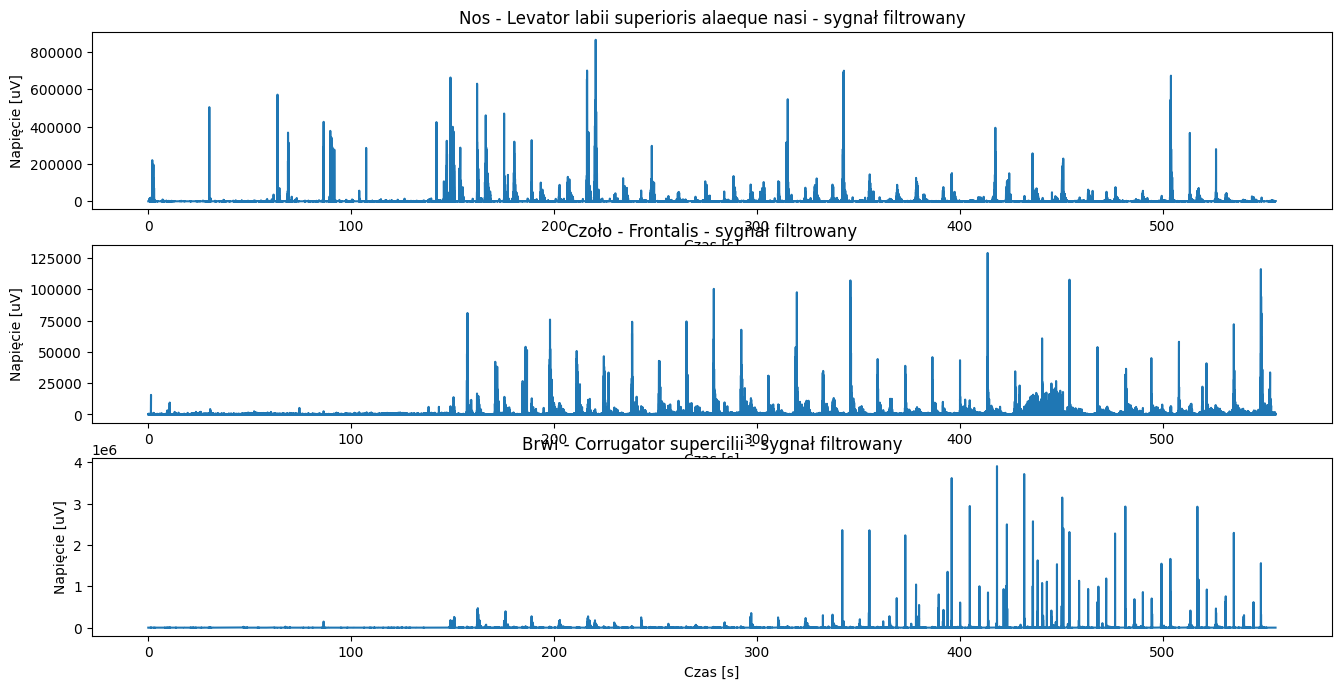

In [18]:
sigs = [No, Cz, Cr]
def filtry(sigs:list=[]) -> list:
  filtered_channels = []
  for channel in sigs:
    [b1,a1]=butter(1,30,fs=Fs,btype='highpass')
    sf1 = filtfilt(b1, a1, channel)
    [b2,a2] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
    sf2 = filtfilt(b2, a2, sf1) #Notch
    [b3,a3] = butter(1,500,fs=Fs,btype='lowpass')
    sf3 = filtfilt(b3, a3, sf2) 
    sf3 = sf3**2
    filtered_channels.append(sf3)
  return filtered_channels

filtered_channels = filtry(sigs)

plt.subplot(3,1,1)
plt.plot(t,filtered_channels[0])
plt.title('Nos - Levator labii superioris alaeque nasi - sygnał filtrowany')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t,filtered_channels[1])
plt.title('Czoło - Frontalis - sygnał filtrowany')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t,filtered_channels[2])
plt.title('Brwi - Corrugator supercilii - sygnał filtrowany')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

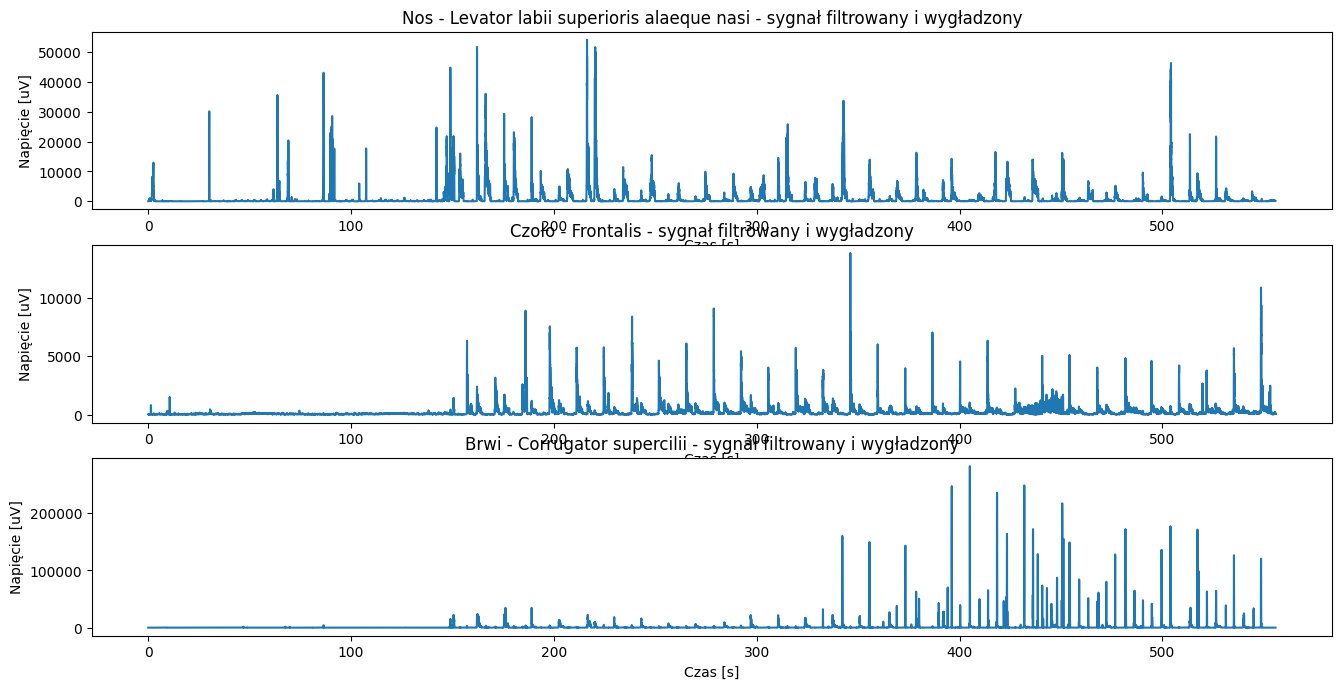

In [19]:
def moving_average(syg, Fs, winlength):
  pds = pd.Series(syg)  
  windows = pds.rolling(int(winlength))  
  moving_averages = windows.mean()
  result = moving_averages.tolist()
  #result = result[int(winlength) - 1:]
  return result

Nma = moving_average(filtered_channels[0], Fs, winlength = 0.1*Fs)
Cma = moving_average(filtered_channels[1], Fs, winlength = 0.1*Fs)
Rma = moving_average(filtered_channels[2], Fs, winlength = 0.1*Fs)

plt.subplot(3,1,1)
plt.plot(t,Nma)
plt.title('Nos - Levator labii superioris alaeque nasi - sygnał filtrowany i wygładzony')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t,Cma)
plt.title('Czoło - Frontalis - sygnał filtrowany i wygładzony')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t,Rma)
plt.title('Brwi - Corrugator supercilii - sygnał filtrowany i wygładzony')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

In [28]:
nazwy_tagów = []
for item in tags:
  if item['name'] not in nazwy_tagów:
    nazwy_tagów.append(item['name'])
print(nazwy_tagów)

#anger corrugator 'an' 'FE'
#nos disgust levator labii superioris alaeque nasi  'Di'
#czolo fear lub zdziwko najlepiej 'AN'

#@title Tagi emocji
emocje= 'di' #@param ["FE", "an", "di"] {allow-input: true}

if emocje != 'di':
  emocje2 = emocje
else:
  emocje2 = 'DI'
def tagowanie(tags):
  result = np.zeros(len(t))
  tagi = []
  for item in tags:
    tagi.append((item['name'], int(item['start_timestamp']*Fs), int(item['end_timestamp']*Fs)))
    if emocje in item['name'] or emocje2 in item['name']:
      result[int(item['start_timestamp']*Fs):int(item['end_timestamp']*Fs)] = 40000
  return result

TAGI = tagowanie(tags)
#plt.plot(TAGI)

['01f_an_c.bmp', '01F_DI_C.bmp', '01F_FE_C.bmp', '02f_an_c.bmp', '02f_di_c.bmp', '02F_FE_C.bmp']


Text(0, 0.5, 'Napięcie [uV]')

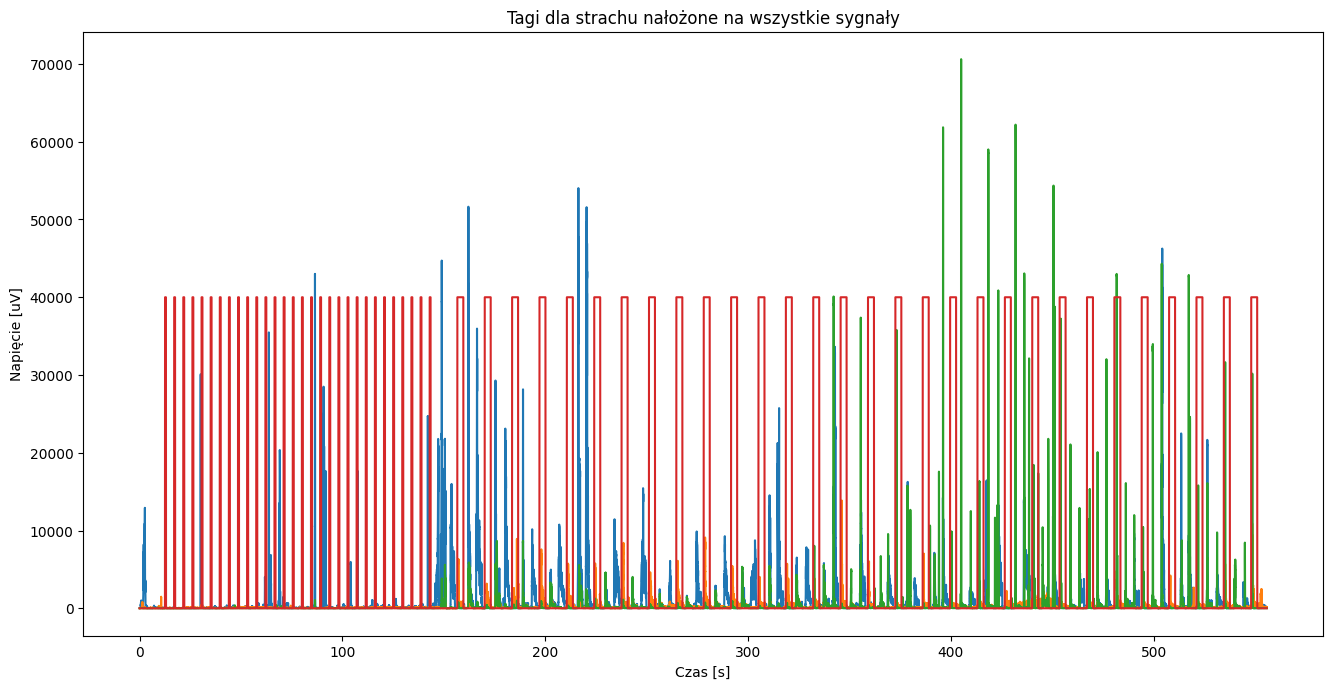

In [21]:
RRma = [item/4 for item in Rma]
plt.plot(t,Nma)
plt.plot(t,Cma)
plt.plot(t,RRma)
plt.plot(t, TAGI)
plt.title('Tagi dla strachu nałożone na wszystkie sygnały')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

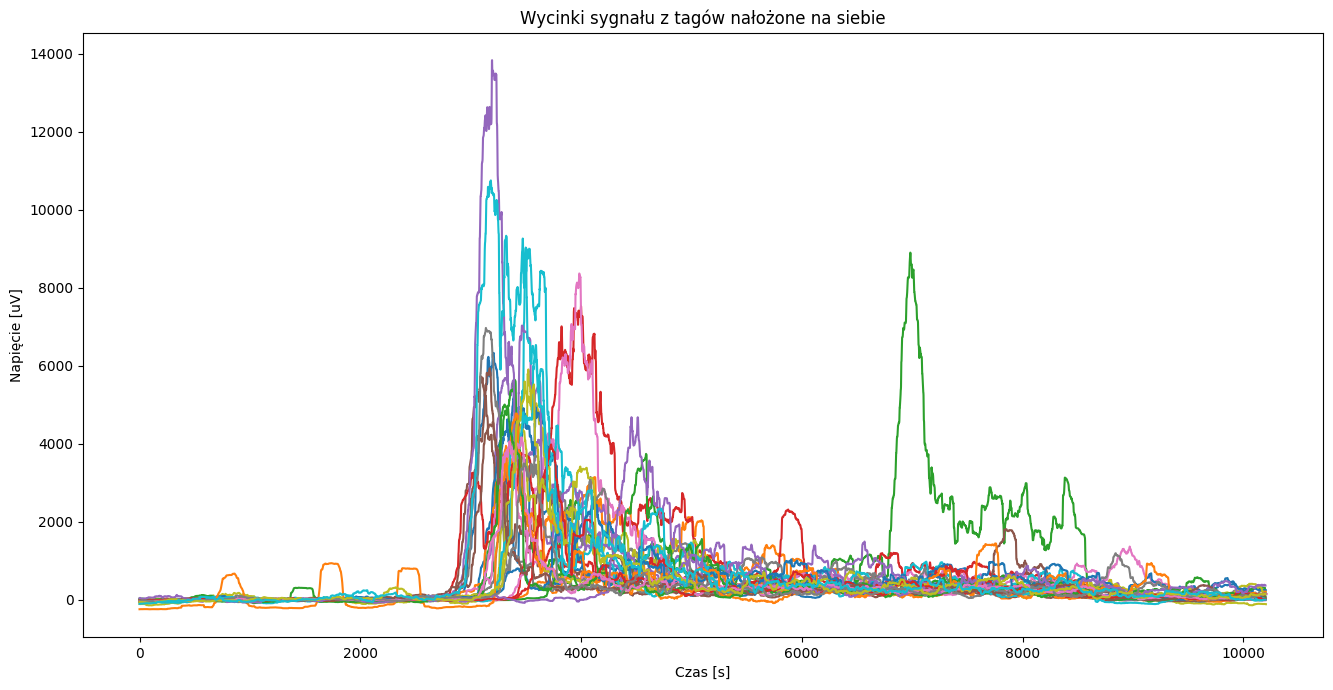

In [22]:
wycinki = []
for ind in range(150*Fs,len(t)):
  if TAGI[ind] != 0 and TAGI[ind-1] == 0:
    start = ind
  if TAGI[ind] != 0 and TAGI[ind+1] == 0:
    wycinki.append(Cma[start-Fs:ind+Fs]-np.mean(Cma[start-Fs:start]))
    start = None

for item in wycinki:
  plt.plot(item)
  plt.title('Wycinki sygnału z tagów nałożone na siebie - procedura aktywna')
  plt.xlabel('Czas [s]')
  plt.ylabel('Napięcie [uV]')

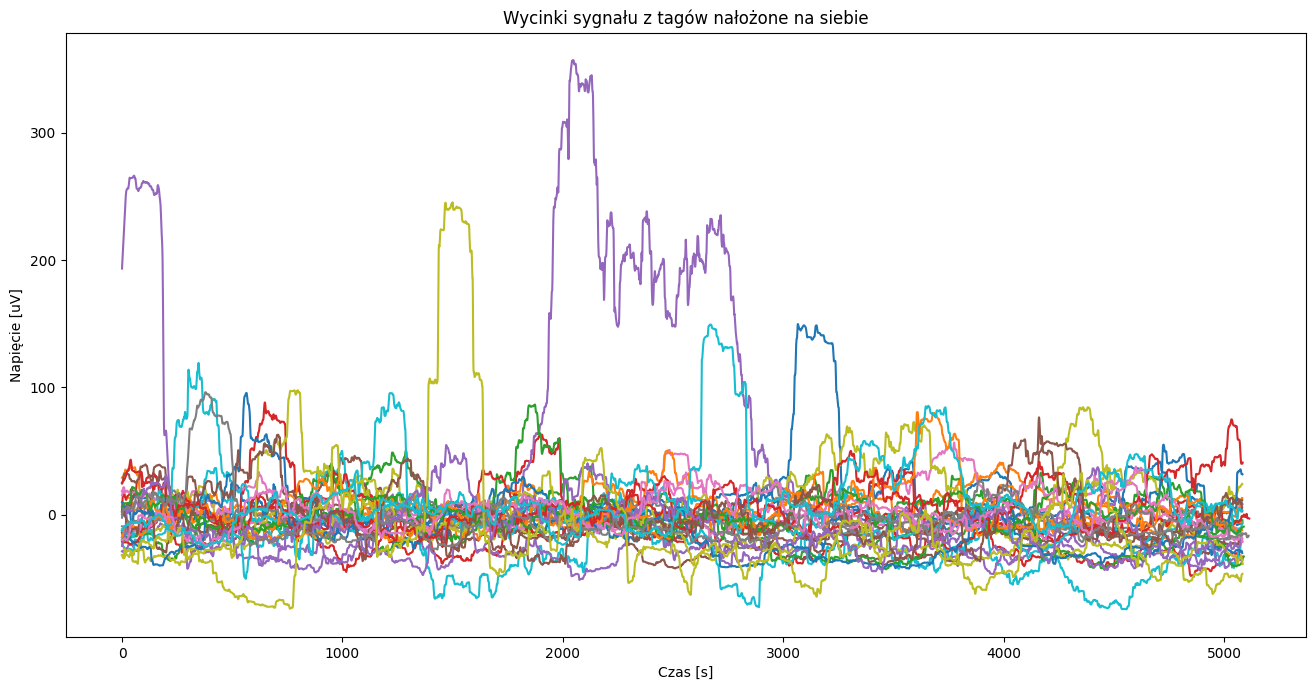

In [26]:
wycinki = []
for ind in range(150*Fs):
  if TAGI[ind] != 0 and TAGI[ind-1] == 0:
    start = ind
  if TAGI[ind] != 0 and TAGI[ind+1] == 0:
    wycinki.append(Cma[start-Fs:ind+Fs]-np.mean(Cma[start-Fs:start]))
    start = None

for item in wycinki:
  plt.plot(item)
  plt.title('Wycinki sygnału z tagów nałożone na siebie - procedura bierna')
  plt.xlabel('Czas [s]')
  plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

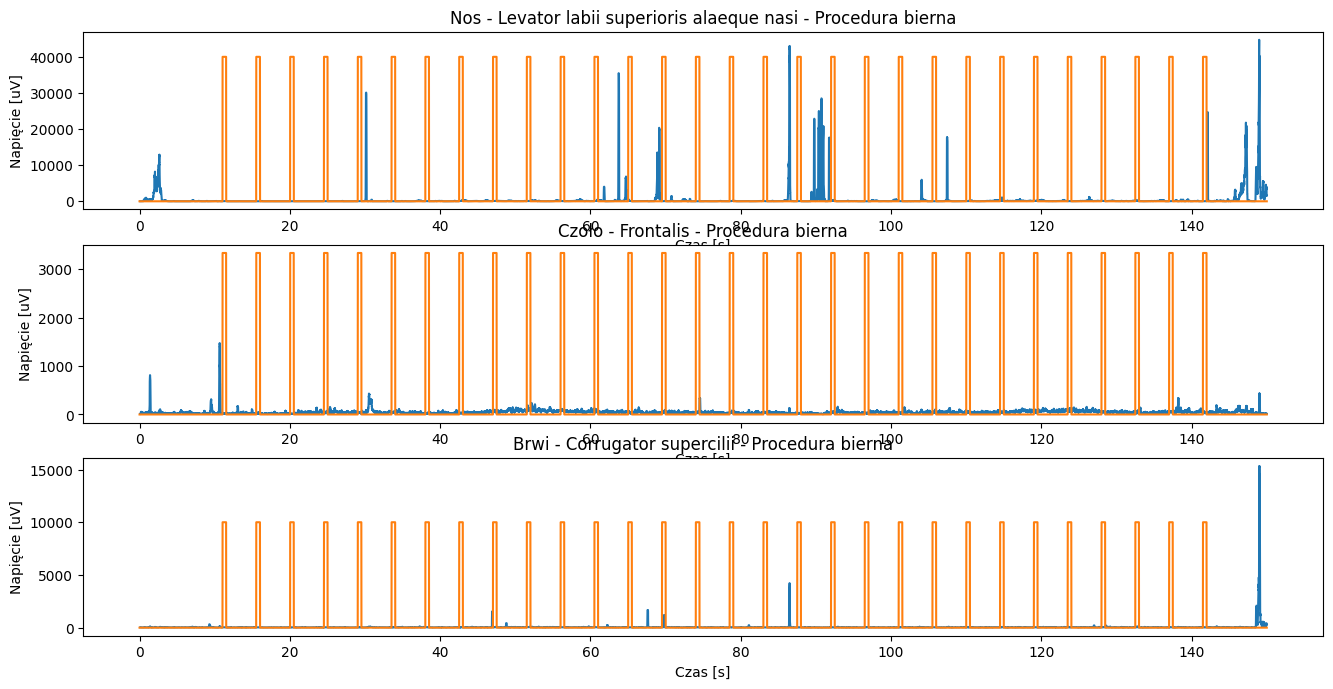

In [29]:
plt.subplot(3,1,1)
plt.plot(t[:150*Fs],Nma[:150*Fs])
plt.plot(t[:150*Fs],TAGI[:150*Fs])
plt.title('Nos - Levator labii superioris alaeque nasi - Procedura bierna')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t[:150*Fs],Cma[:150*Fs])
plt.plot(t[:150*Fs],TAGI[:150*Fs]/12)
plt.title('Czoło - Frontalis - Procedura bierna')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t[:150*Fs],Rma[:150*Fs])
plt.plot(t[:150*Fs],TAGI[:150*Fs]/4)
plt.title('Brwi - Corrugator supercilii - Procedura bierna')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

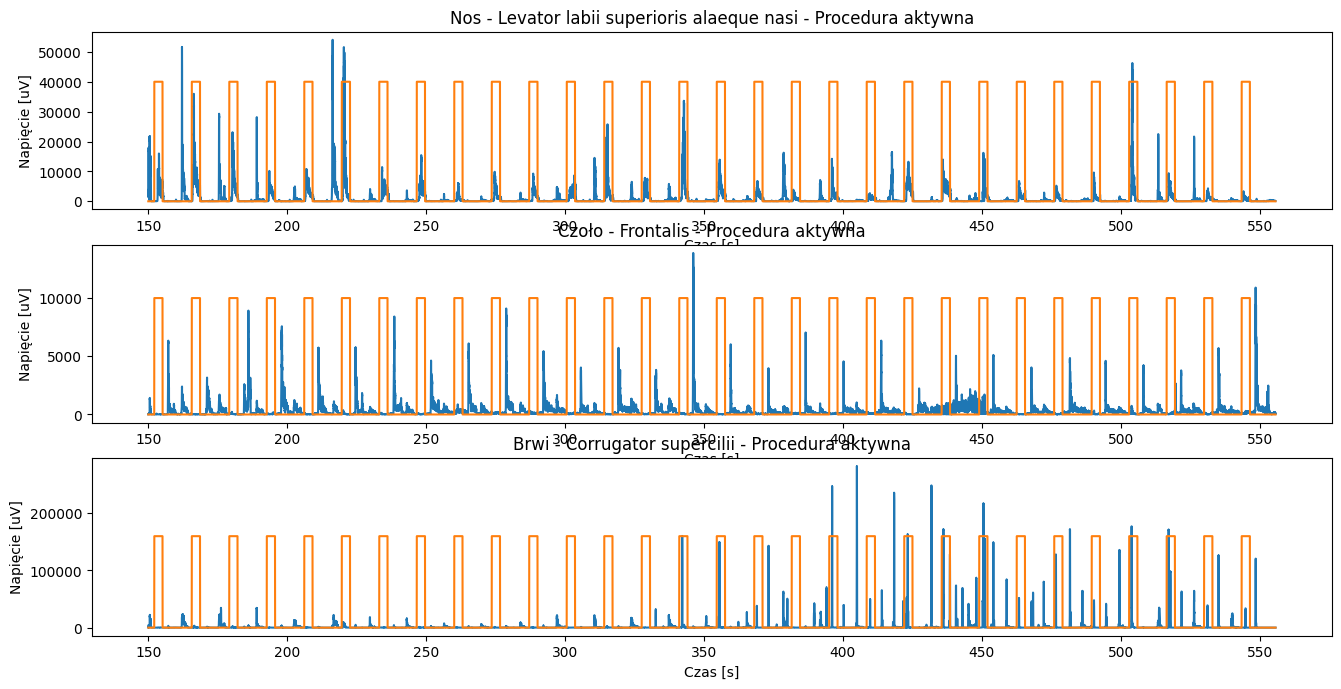

In [30]:
plt.subplot(3,1,1)
plt.plot(t[150*Fs:],Nma[150*Fs:])
plt.plot(t[150*Fs:],TAGI[150*Fs:])
plt.title('Nos - Levator labii superioris alaeque nasi - Procedura aktywna')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t[150*Fs:],Cma[150*Fs:])
plt.plot(t[150*Fs:],TAGI[150*Fs:]/4)
plt.title('Czoło - Frontalis - Procedura aktywna')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(t[150*Fs:],Rma[150*Fs:])
plt.plot(t[150*Fs:],TAGI[150*Fs:]*4)
plt.title('Brwi - Corrugator supercilii - Procedura aktywna')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

In [31]:
'''
#@title String fields
emocje= 'value' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
print(text_and_dropdown)
#@title Number fields
number_input = 10.0 #@param {type:"number"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}
print(number_input)
print(number_slider)
'''

'\n#@title String fields\nemocje= \'value\' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}\nprint(text_and_dropdown)\n#@title Number fields\nnumber_input = 10.0 #@param {type:"number"}\nnumber_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}\nprint(number_input)\nprint(number_slider)\n'